# This Notebook uses ATAC-seq generated data

Refer to `ATAC-py.ipynb` for prior data analysis pipeline

In [123]:
library(repr)
options(repr.plot.width=7, repr.plot.height=7)

In [2]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DiffBind")

Bioconductor version 3.9 (BiocManager 1.30.4), R 3.6.1 (2019-07-05)
Installing package(s) 'DiffBind'
also installing the dependencies ‘GSEABase’, ‘hwriter’, ‘Category’, ‘graph’, ‘RBGL’, ‘AnnotationForge’, ‘Rgraphviz’, ‘base64url’, ‘rappdirs’, ‘ShortRead’, ‘rjson’, ‘GOstats’, ‘batchtools’, ‘amap’, ‘systemPipeR’

Warning message in install.packages(pkgs = doing, lib = lib, repos = repos, ...):
“installation of package ‘DiffBind’ had non-zero exit status”installation path not writeable, unable to update packages: AnnotationDbi,
  backports, BiocManager, BiocParallel, biomaRt, boot, callr, curl, data.table,
  devtools, digest, ellipsis, foreign, GenomicRanges, ggplot2, hms, htmltools,
  htmlwidgets, httpuv, httr, IRanges, lambda.r, later, limma, matrixStats,
  mgcv, nlme, pbapply, pkgbuild, pkgconfig, promises, Rcpp, reticulate,
  Rhtslib, Rsamtools, RSQLite, rsvd, rtracklayer, S4Vectors, Seurat, shiny,
  sys, tidyr, vegan, whisker
Update old packages: 'KEGGREST', 'RcppArmadillo'


In [5]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [6]:
library(DESeq2)
library(apeglm)
library(EnhancedVolcano)
library(pheatmap)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    un

In [12]:
list.files('.', '(readcounts)|(Peaks).txt')

[1] "ATAC_genebody_NumberofPeaks.txt"     
[2] "ATAC_genebody_Peak_rawreadcounts.txt"
[3] "ATAC_Promoter_NumberofPeaks.txt"     
[4] "ATAC_Promoter_Peak_rawreadcounts.txt"

# Promoter region DESeq



In [1]:
setwd('/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/')

In [43]:
peak_cnts_pro <- read.table("diffbind_consensu_min2overlap_readcounts_promoterRegion.txt", header=F, stringsAsFactors = F)

In [44]:
peak_cnts_pro <- peak_cnts_pro %>% select(19,4:15)

In [45]:
colnames(peak_cnts_pro) <- c("gene_id","A1", "A2", "A3","A4","A5","A6","A7","A8","A9","A10","A11","A12")

In [57]:
peak_cnts_pro <- peak_cnts_pro %>% group_by(gene_id) %>% summarise_all(sum) # group peaks into one gene per row

In [59]:
peak_cnts_pro <- peak_cnts_pro %>% column_to_rownames('gene_id') # column to row

In [60]:
peak_cnts_pro %>% str

'data.frame':	13196 obs. of  12 variables:
 $ A1 : int  48 168 60 151 349 167 75 119 120 168 ...
 $ A2 : int  45 127 33 111 245 125 76 76 106 133 ...
 $ A3 : int  48 126 37 128 237 117 85 101 97 127 ...
 $ A4 : int  51 97 65 96 240 138 53 108 93 123 ...
 $ A5 : int  47 191 54 105 278 178 59 82 72 152 ...
 $ A6 : int  64 251 73 186 328 253 95 118 124 278 ...
 $ A7 : int  25 124 67 107 227 135 62 117 70 168 ...
 $ A8 : int  66 185 74 139 360 198 129 118 63 262 ...
 $ A9 : int  104 375 162 268 726 367 222 222 204 501 ...
 $ A10: int  72 248 71 171 489 237 119 173 84 303 ...
 $ A11: int  121 331 39 176 757 214 291 292 134 417 ...
 $ A12: int  87 296 15 131 719 207 237 279 149 379 ...


In [22]:
all.sample.annotation <- read.table('ATACseqSampleName.csv', stringsAsFactors=F, col.names = c('sample', 'group'))

In [63]:
all.sample.annotation %>% t

sample,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
group,ES,ES,H1,H1,H4,H4,H16,H16,H24,H24,D5,D5


In [64]:
# sample names for WT at different time points: 15H , 1D, 2D, 4D, 7D
cols3 <- all.sample.annotation %>% pull(sample)

In [68]:
cnts3 <- peak_cnts_pro[,cols3]

In [29]:
gtf_lookup = read.csv('/gpfs/commons/groups/sanjana_lab/cdai/ref_genome/gencode.v31.primary_assembly.annotation.gene_idTOgene_name.txt') #gencode gene_id to gene_name lookup

In [69]:
cnts3 %>% head

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000419.12,48,45,48,51,47,64,25,66,104,72,121,87
ENSG00000000457.14,168,127,126,97,191,251,124,185,375,248,331,296
ENSG00000000971.15,60,33,37,65,54,73,67,74,162,71,39,15
ENSG00000001036.13,151,111,128,96,105,186,107,139,268,171,176,131
ENSG00000001167.14,349,245,237,240,278,328,227,360,726,489,757,719
ENSG00000001461.17,167,125,117,138,178,253,135,198,367,237,214,207


In [70]:
gene_ids3 = rownames_to_column(cnts3,'gene_id')[,1:2]

In [72]:
gtf_lookup$gene_id <- as.character(gtf_lookup$gene_id)
gene_names3 = left_join(gene_ids3, gtf_lookup, 'gene_id') %>% pull(gene_name) %>% as.character

In [73]:
gene_names3 %>% str

 chr [1:13196] "DPM1" "SCYL3" "CFH" "FUCA2" "NFYA" "NIPAL3" "LAS1L" "ENPP4" ...


In [74]:
coldata3 <- all.sample.annotation %>% column_to_rownames('sample')

In [75]:
coldata3 %>% t

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
group,ES,ES,H1,H1,H4,H4,H16,H16,H24,H24,D5,D5


In [76]:
cnts3 %>% head

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000419.12,48,45,48,51,47,64,25,66,104,72,121,87
ENSG00000000457.14,168,127,126,97,191,251,124,185,375,248,331,296
ENSG00000000971.15,60,33,37,65,54,73,67,74,162,71,39,15
ENSG00000001036.13,151,111,128,96,105,186,107,139,268,171,176,131
ENSG00000001167.14,349,245,237,240,278,328,227,360,726,489,757,719
ENSG00000001461.17,167,125,117,138,178,253,135,198,367,237,214,207


In [77]:
coldata3 %>% t
cnts3 %>% colnames %>% t

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
group,ES,ES,H1,H1,H4,H4,H16,H16,H24,H24,D5,D5


A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12


In [78]:
dds3 <- DESeqDataSetFromMatrix(countData = cnts3, colData = coldata3, design = ~ group)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

In [79]:
all(rownames(dds3) == gene_ids3$gene_id) # make sure all gene_ids are the same as the gene ids in dds

[1] TRUE

In [80]:
mcols(dds3) <- cbind(mcols(dds3), 'gene_name' = gene_names3) # adding gene_names to counts dds

In [81]:
keep3 <- rowSums(counts(dds3)) >= 10 # pre-analysis filter to remove very low read count genes
dds3 <- dds3[keep3,]

In [82]:
dim(dds3)

[1] 13196    12

In [83]:
counts(dds3) %>% head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
ENSG00000000419.12,48,45,48,51,47,64,25,66,104,72,121,87
ENSG00000000457.14,168,127,126,97,191,251,124,185,375,248,331,296
ENSG00000000971.15,60,33,37,65,54,73,67,74,162,71,39,15
ENSG00000001036.13,151,111,128,96,105,186,107,139,268,171,176,131
ENSG00000001167.14,349,245,237,240,278,328,227,360,726,489,757,719
ENSG00000001461.17,167,125,117,138,178,253,135,198,367,237,214,207


In [84]:
dds3 <- DESeq(dds3) # build model

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [85]:
resultsNames(dds3) # model coefficients

[1] "Intercept"       "group_ES_vs_D5"  "group_H1_vs_D5"  "group_H16_vs_D5"
[5] "group_H24_vs_D5" "group_H4_vs_D5"

### Volcano plots

#### 1H vs. ES

In [119]:
res3a <- results(dds3, contrast = c('group','H1','ES')) # modelling ES vs. +DOX

# add gene_name to result
if (all(rownames(res3a) == rownames(dds3))) {
    res3a.df <- cbind(res3a, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))
}  else {
    print("Rownames don't match!")
}

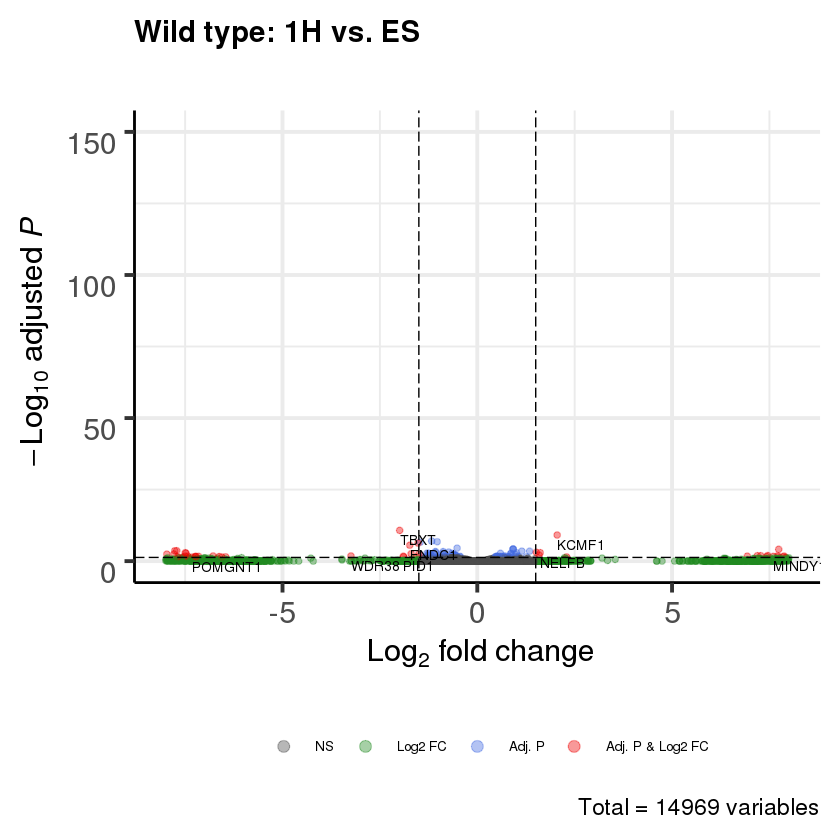

In [179]:
EnhancedVolcano(res3a.df, lab = res3a.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-8,8), ylim=c(0,150),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 1H vs. ES", subtitle="", pCutoff = 0.05, FCcutoff = 1.5,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

#### 4H vs. ES

In [120]:
res3b <- results(dds3, contrast = c('group','H4','ES'))

# add gene_name to result
if (all(rownames(res3b) == rownames(dds3))) {
    res3b.df <- cbind(res3b, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))   
}  else {
    print("Rownames don't match!")
}

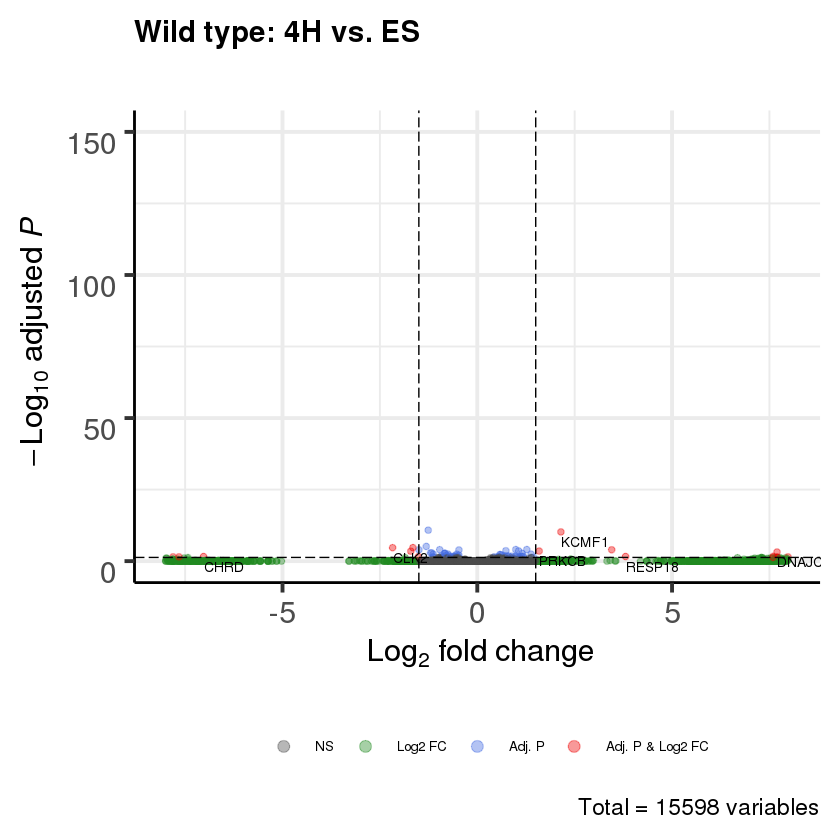

In [182]:
EnhancedVolcano(res3b.df, lab = res3b.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-8,8), ylim=c(0,150),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 4H vs. ES", subtitle="", pCutoff = 0.05, FCcutoff = 1.5,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

#### H16 vs. ES

In [121]:
res3c <- results(dds3, contrast = c('group','H16','ES'))

# add gene_name to result
if (all(rownames(res3c) == rownames(dds3))) {
    res3c.df <- cbind(res3c, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))   
}  else {
    print("Rownames don't match!")
}

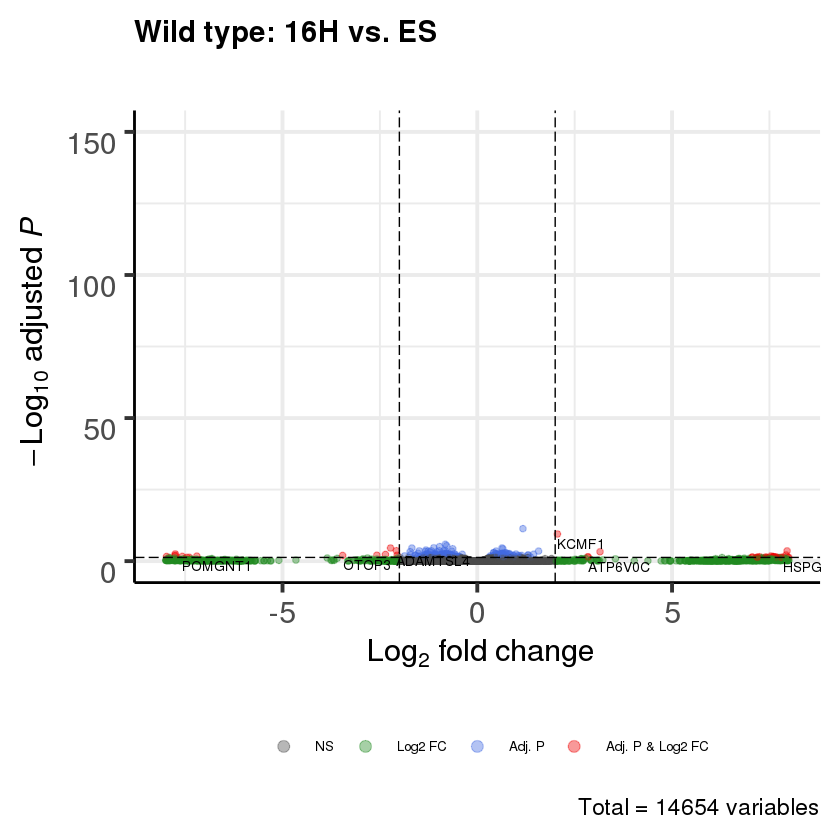

In [184]:
EnhancedVolcano(res3c.df, lab = res3c.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-8,8), ylim=c(0,150),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 16H vs. ES", subtitle="", pCutoff = 0.05, FCcutoff = 2,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

#### 24H vs. ES

In [91]:
res3d <- results(dds3, contrast = c('group','H24','ES'))

# add gene_name to result
if (all(rownames(res3d) == rownames(dds3))) {
    res3d.df <- cbind(res3d, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))
}  else {
    print("Rownames don't match!")
}

In [97]:
res3d.df %>% head(2)

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000419.12,59.77386,-0.01017202,0.3178535,-0.03200223,0.9744703,0.9894718,DPM1
ENSG00000000457.14,191.99217,0.15167966,0.1722280,0.88069096,0.3784851,0.6967510,SCYL3


In [98]:
# How many significant genes?
res3d.df %>% filter(padj < 0.05) %>% dim

# How many significant and FC > 1.5? 
res3d.df %>% filter(padj < 0.05 & abs(log2FoldChange) > 1.5) %>% dim

[1] 626   8

[1] 16  8

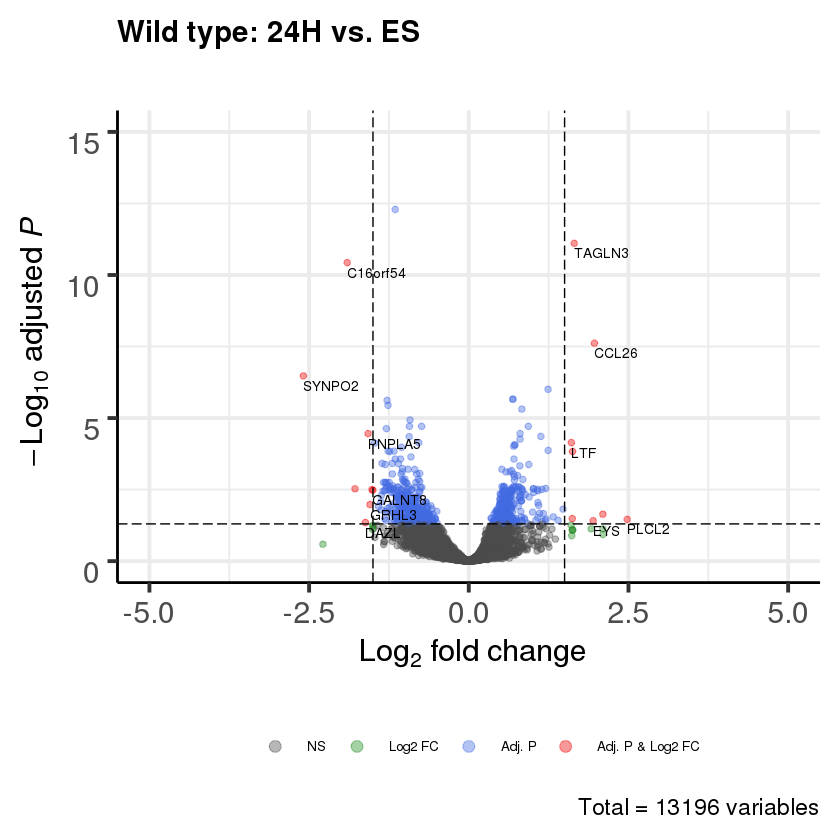

In [102]:
EnhancedVolcano(res3d.df, lab = res3d.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-5,5), ylim=c(0,15),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 24H vs. ES", subtitle="", pCutoff = .05, FCcutoff = 1.5,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

#### 5D vs. ES

In [103]:
res3e <- results(dds3, contrast = c('group','D5','ES'))

# add gene_name to result
if (all(rownames(res3e) == rownames(dds3))) {
    res3e.df <- cbind(res3e, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))
}  else {
    print("Rownames don't match!")
}

In [167]:
res3e.df %>% head

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000419.12,59.77386,0.2249992,0.3145903,0.7152135,4.744771e-01,0.5985278706,DPM1
ENSG00000000457.14,191.99217,0.1672012,0.1718921,0.9727103,3.306973e-01,0.4585976449,SCYL3
ENSG00000000971.15,61.11724,-1.7097659,0.4072577,-4.1982406,2.689968e-05,0.0002109394,CFH
ENSG00000001036.13,141.51447,-0.6957654,0.2130872,-3.2651674,1.093994e-03,0.0047881737,FUCA2
ENSG00000001167.14,371.78924,0.3982598,0.1309563,3.0411647,2.356649e-03,0.0091167384,NFYA
ENSG00000001461.17,184.18875,-0.3899967,0.1787029,-2.1823751,2.908186e-02,0.0701964860,NIPAL3


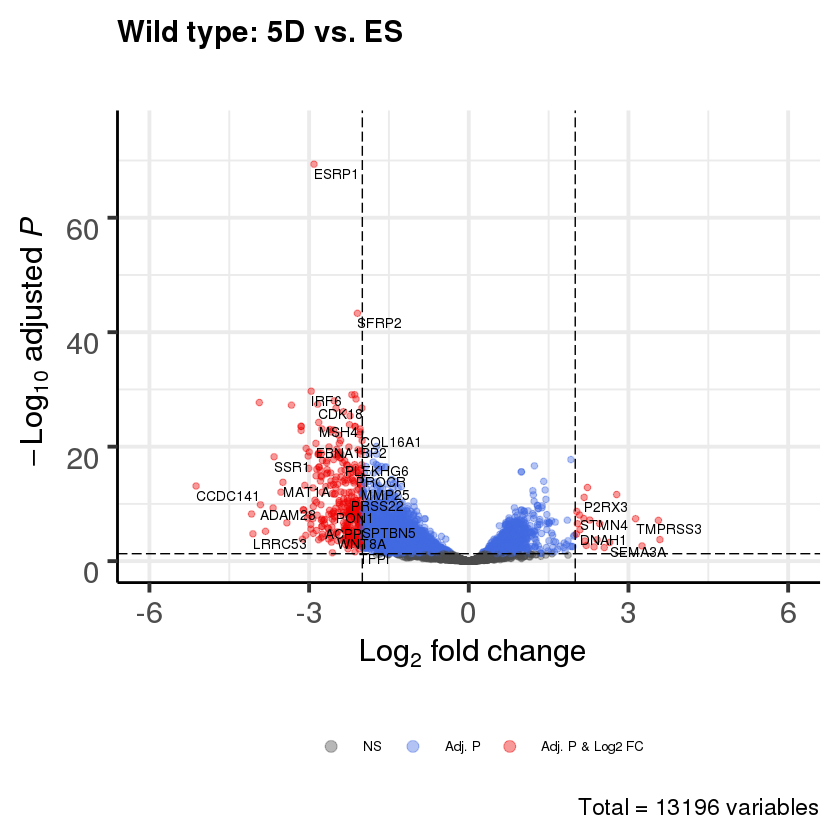

In [107]:
EnhancedVolcano(res3e.df, lab = res3e.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-6,6), ylim=c(0,75),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 5D vs. ES", subtitle="", pCutoff = .05, FCcutoff = 2,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

### Get genes at each temporal point

In [123]:
sig_genes_3a <- res3a.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character
sig_genes_3b <- res3b.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character 
sig_genes_3c <- res3c.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character
sig_genes_3d <- res3d.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character
sig_genes_3e <- res3e.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character

##### Number of genes significant in each tempral profile

In [124]:
res3e.df %>% filter(gene_name == 'ZBTB18')

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000179456.10,325.8522,0.6257008,0.1561191,4.007843,6.127573e-05,0.0004280543,ZBTB18


In [125]:
counts(dds3, normalized=T) %>% as.data.frame %>% head #%>% rownames_to_column('gene_id') %>% filter(gene_id == 'ENSG00000036549') %>% t

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000419.12,54.88538,61.90347,64.17453,70.00271,57.76992,56.33439,35.96184,64.44960,56.95640,58.85375,75.00503,60.98926
ENSG00000000457.14,192.09884,174.70533,168.45814,133.14241,234.76711,220.93644,178.37075,180.65419,205.37164,202.71846,205.17906,207.50371
ENSG00000000971.15,68.60673,45.39587,49.46787,89.21914,66.37395,64.25641,96.37774,72.26168,88.72055,58.03633,24.17518,10.51539
ENSG00000001036.13,172.66027,152.69521,171.13208,131.76981,129.06045,163.72182,153.91669,135.73477,146.77227,139.77765,109.09823,91.83441
ENSG00000001167.14,399.06247,337.02998,316.86174,329.42452,341.70291,288.71375,326.53355,351.54329,397.59950,399.71504,469.24636,504.03772
ENSG00000001461.17,190.95539,171.95407,156.42542,189.41910,218.78820,222.69689,194.19396,193.34881,200.99038,193.72692,132.65353,145.11239


In [126]:
sig_genes_3a %>% length
sig_genes_3b %>% length
sig_genes_3c %>% length
sig_genes_3d %>% length
sig_genes_3e %>% length

[1] 0

[1] 4

[1] 214

[1] 626

[1] 4995

##### Build a matrix that shows how significant genes show up at different time point.

 .|15H |1D|2D|4D|7D
:--:|:--:|:--:|:--:|:--:|:--:
Gene1|log2FC|log2FC|log2FC|log2FC|log2FC
Gene2| |log2FC|log2FC|log2FC|log2FC
...
GeneN| | | |log2FC|log2FC



In [127]:
length(c(1,1,1,1,1)==5) & is.numeric(c(1,1,1,1,1))

[1] TRUE

In [169]:
# A function to convert a vector of 5 binary numbers (represented in integer) into an integer. 
# This esentially represents/flags gene expression time profile.
# e.g. c(1,1,1,1,1) => 31, c(0,0,1,0,0) => 8
bit.like.to.int <- function(c) { 
    if (length(c) == 5 & is.numeric(c)){
        return(c[1]*2^4 + c[2]*2^3 + c[3]*2^2 + c[4]*2^1 + c[5]*2^0)
    }
    else {
        print("Vector must be numeric with a length of 5!")
    }
}

# DESeq2 results from each time point, combined into a list
res.all.times <- list(res3a.df, res3b.df, res3c.df, res3d.df, res3e.df) 

# first get all significant gene_ids from all 5 time point
sig.geneID.all.times <- c()
fdr.cutoff <- 0.05
for (df in res.all.times) { # iterate through the results from all 5 time points
    geneID.temp <- df %>% filter(padj < fdr.cutoff) %>% pull(gene_id) %>% as.character # get gene_ids of significant genes from results of all 5 time points
    sig.geneID.all.times <- c(sig.geneID.all.times, geneID.temp) # a list of gene ids for all the genes that are significant at any time point
}
sig.geneID.all.times <- unique(sig.geneID.all.times) # remove duplicates gene_ids

# create a expression table with Log2FC at all 5 time points. The rows are genes that are significant at any timepoint. 
# Value of NA means the gene is not significant at the given time point

#make a df of gene_id
expr.tbl <- sig.geneID.all.times %>% as.data.frame(stringsAsFactors=F) %>% rename('.'='gene_id')

#create a list of log2FC for all the genes listed in expr.tbl at each time point
FC.all.times <- c()
for (df in res.all.times) {
    x <- expr.tbl %>% left_join(df[df$padj < fdr.cutoff, c('gene_id', 'log2FoldChange')], c('gene_id')) %>% 
        select(log2FoldChange) %>% pull(log2FoldChange)
    FC.all.times <- c(FC.all.times, list(x)) # log2FC for the gene_id
}

#add log2FC at each time point as a column, then left join gtf_lookup to add gene name
expr.tbl <- expr.tbl %>% add_column('1H' = FC.all.times[[1]]) %>% add_column('4H' = FC.all.times[[2]]) %>%
             add_column('16H' = FC.all.times[[3]]) %>% add_column('24H' = FC.all.times[[4]]) %>%
             add_column('5D' = FC.all.times[[5]]) %>% left_join(gtf_lookup, 'gene_id')


# create a logic matrix where 1: this gene is significant at this time point, and 0: not
logic.matrix <- apply(expr.tbl[,c(2:6)], MARGIN = 2, function(x) {!is.na(x)}) %>% as.data.frame %>% 
        mutate_all(funs(as.integer))

# expression time profile flag. e.g. a number of 7 represents this gene is activated from D2 through D7, while 1 means only activated on D7
expr.flags <- c()
for (i in 1:dim(logic.matrix)[1]) {
    x <- logic.matrix[i,] %>% as.numeric # convert each row e.g.[1,0,0,0,0] into a numeric vector of 5 elements, eg.c(1,0,0,0,0)
    x <- bit.like.to.int(x) # calculate bit value (represented in int, eg. 00100 = 8)
    expr.flags <- c(expr.flags, x)
}

expr.tbl <- cbind(expr.tbl, expr.flag=expr.flags) # add expression flags 
expr.tbl <- expr.tbl[,c(1,7:8,2:6)]

In [170]:
expr.tbl %>% head
expr.tbl %>% dim

gene_id,gene_name,expr.flag,1H,4H,16H,24H,5D
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000090932.10,DLL3,15,NA,1.0980253,0.8291580,1.1287681,0.9689608
ENSG00000162992.3,NEUROD1,15,NA,0.9615801,0.8092058,0.8293271,1.3052551
ENSG00000166482.11,MFAP4,8,NA,1.1531903,NA,NA,NA
ENSG00000188452.14,CERKL,15,NA,0.9615801,0.8092058,0.8293271,1.3052551
ENSG00000004700.16,RECQL,7,NA,NA,0.7030515,0.6735579,0.8788419
ENSG00000006606.8,CCL26,7,NA,NA,1.5826233,1.9674747,1.0737009


[1] 5079    8

In [171]:
#TF list
tflist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/TFlist.csv', stringsAsFactors = F, col.names='gene_name') %>% pull(var = gene_name)

In [131]:
correct_tf_gene_name <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/Refseq_to_Gencode_genenames.csv', header = F, stringsAsFactors = F) %>% rename('V1'='HGNC', 'V2'='Gencode')

In [132]:
correct_tf_gene_name %>% head

HGNC,Gencode
<chr>,<chr>
AES,TLES
ANKRD32,SLF1
CCRN4L,NOCT
CNOT2,AC092881.1
CRAMP1L,CRAMP1
FAIM3,FCMR


In [133]:
correct_tf_gene_name

HGNC,Gencode
<chr>,<chr>
AES,TLES
ANKRD32,SLF1
CCRN4L,NOCT
CNOT2,AC092881.1
CRAMP1L,CRAMP1
FAIM3,FCMR
HDGFRP2,HDGFL2
HKR1,ZNF875
MKL1,MRTFA


In [206]:
gtf_lookup %>% filter(gene_id == 'ENSG00000198039.11')

gene_name,gene_id
<fct>,<chr>
AC092161.1,ENSG00000198039.11


In [549]:
correct_tf_gene_name %>% filter(HGNC == 'ZZZ3') %>% pull(Gencode)

[1] "AC118549.1"

In [555]:
tflist[1988]

[1] "AC118549.1"

In [558]:
which(tflist == 'AC092161.1')

[1] 1754 1773

In [552]:
correct_tf_gene_name$Gencode[1]

[1] "TLES"

In [554]:
for (tf in tflist) {
    if (tf %in% correct_tf_gene_name$HGNC) {
        new_name <- correct_tf_gene_name %>% filter(HGNC == tf) %>% pull(Gencode)
        tflist[which(tflist == tf)] <- new_name
    }
}

In [518]:
tflist %>% head

[1] "AATF"  "ABL1"  "ABT1"  "ABTB1" "ADNP"  "AEBP1"

In [173]:
#120 hit list
hitlist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/HS_td-VStd+_td-VSdox120.csv', header = F, stringsAsFactors = F) %>% pull

In [174]:
hitlist %>% t

PHOX2A,TAF1L,TFEB,VAX2,SNAI2,ELK3,ISL2,ZBTB43,ZNF200,MLLT6,⋯,ZBTB18,CHD5,CTNNB1,ZNF554,UBE2K,HTATIP2,NEUROG3,SMAD3,LHX4,PRDM6


In [175]:
expr.tbl <- expr.tbl %>% mutate(isTF=if_else(gene_name %in% tflist, 'Yes', 'No')) %>% 
             mutate(isHIT=if_else(gene_name %in% hitlist, 'Yes', 'No'))

In [176]:
expr.tbl %>% write.csv('ATAC_FoldChangeByTimePoints.csv', row.names=F)

In [211]:
ano3 <- coldata3

In [134]:
tf.heatmap.genes.3e <- res3e_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character
cnts3_tf[,c(2:16)] %>% filter(gene_name %in% tf.heatmap.genes.3e) %>% column_to_rownames('gene_name') %>% mutate_all(quadroot) %>% as.matrix %>%
                pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, annotation = ano3, fontsize=8, treeheight_row=0,
                main = paste0('+DOX vs. ES at 7D, Screened TF Genes (fdr<',fdr,', log2FC>',FC.threshold,')'))

ERROR: Error in eval(lhs, parent, parent): object 'res3e_tf' not found


##### genes that are significant from 1H to 5D

In [135]:
sig_genes_3a %>% intersect(sig_genes_3b) %>% intersect(sig_genes_3c) %>% intersect(sig_genes_3d) %>%
                 intersect(sig_genes_3e) %>% length

[1] 0

##### genes that become significant at 4H and continues to be significant at 16H, 24H and Day 5

In [136]:
sig_genes_3b %>%  setdiff(sig_genes_3a)  %>% intersect(sig_genes_3c) %>% 
            intersect(sig_genes_3d) %>% intersect(sig_genes_3e) %>% length

[1] 3

##### genes that become significant at 16H and continues to be significant at 24H and Day 5

In [137]:
sig_genes_3c %>% setdiff(unique(c(sig_genes_3a,sig_genes_3b))) %>% intersect(sig_genes_3d) %>% intersect(sig_genes_3e) %>% length

[1] 126

##### genes that become significant at 24H and continues to be significant at Day 5

In [138]:
sig_genes_3e %>% setdiff(unique(c(sig_genes_3a,sig_genes_3b, sig_genes_3c))) %>% intersect(sig_genes_3e) %>% length

[1] 4819

##### genes that are only significant at Day 5

In [139]:
sig_genes_3e %>% setdiff(unique(c(sig_genes_3a,sig_genes_3b, sig_genes_3c, sig_genes_3d))) %>% length

[1] 4378

## Zoom in on ~2000 screened TF

In [140]:
#TF list
tflist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/TFlist.csv', stringsAsFactors = F, col.names='gene_name') %>% pull(var = gene_name)

In [141]:
tflist[1:5]
length(tflist)

[1] "AATF"  "ABL1"  "ABT1"  "ABTB1" "ADNP"

[1] 1988

#### Result for each temporal stage
`gene`,`padj`,`log2FoldChange` for each temporal point (15H - 7D) for the 1988 TF genes.

Selection criteria:
- `padj` is not na
- `gene_name` in `tflist`

In [142]:
res3d.df %>% tail

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
13191,ENSG00000287363.1,22.95489,1.62396139,0.5884634,2.7596641,0.005786082,0.08182459,AL096814.2
13192,ENSG00000287542.1,143.47061,0.06822577,0.2150264,0.3172902,0.751023432,0.90550531,AC098582.1
13193,ENSG00000287694.1,32.57506,-0.45146464,0.4358343,-1.0358630,0.300266066,0.62721321,AC106741.1
13194,ENSG00000287856.1,162.06801,0.07835424,0.1936141,0.4046928,0.685703307,0.87582653,AL445524.2
13195,ENSG00000288000.1,120.69046,0.27009295,0.2246850,1.2020963,0.229326221,0.56113273,AL031681.2
13196,ENSG00000288053.1,110.25587,-0.15783984,0.2213475,-0.7130862,0.475792427,0.76225035,AC231657.3


In [143]:
# get DGE result, namely FC and padj, for each temproal point
res3a_tf <- res3a.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)
res3b_tf <- res3b.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)
res3c_tf <- res3c.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)
res3d_tf <- res3d.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)
res3e_tf <- res3e.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)

In [144]:
# Determine and annotate whether a TF screen listed gene is up or down regulated
fdr = 0.05
FC.threshold = 1.5

In [145]:
res3a_tf <- res3a_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 
res3b_tf <- res3b_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 
res3c_tf <- res3c_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 
res3d_tf <- res3d_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 
res3e_tf <- res3e_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 

In [146]:
res3a_tf %>% head

gene_name,gene_id,padj,log2FoldChange,DGE
<chr>,<chr>,<dbl>,<dbl>,<chr>
NFYA,ENSG00000001167.14,0.9992379,-0.191985511,No Change
ARX,ENSG00000004848.8,0.9992379,-0.033792613,No Change
UPF1,ENSG00000005007.12,0.9992379,0.570607118,No Change
CREBBP,ENSG00000005339.14,0.9992379,0.002380666,No Change
SOX8,ENSG00000005513.10,0.9992379,0.231548685,No Change
ZNF195,ENSG00000005801.18,0.9992379,0.161616070,No Change


##### Summary plot for TF screen selected genes that are up/down regulated

In [148]:
# summarize gene counts for TF screen selected genes
c <- c()
for (l in list(res3a_tf, res3b_tf, res3c_tf, res3d_tf, res3e_tf)) {
    gcount <- l %>% group_by(DGE) %>% summarize( "gene_count"=n()) %>% pull(gene_count) # get the count of genes
    c <- c(c,gcount)
}

tfs.bar.data <- data.frame(matrix(c, nrow=3))

colnames(tfs.bar.data) = c('1H', '4H', '16', '24H','5D')
rownames(tfs.bar.data) = c('Down', 'No Change', 'Up')

tfs.bar.data <- tfs.bar.data %>% gather(condition, gene_counts) %>% add_column(DGE=rep(c('Down', 'No Change', 'Up'),5), .before=2)

ERROR: Error in names(x) <- value: 'names' attribute [5] must be the same length as the vector [3]


In [147]:
ggplot(data = tfs.bar.data) + geom_bar(aes(x=condition, y=gene_counts, fill=DGE),position=position_fill(reverse = TRUE), stat="identity") +
            labs(y="% of Screened Gene", x="Temporal", title = "Accessible Promoter Region") +
            scale_fill_manual(name='+DOX vs. ES', values=c('lightslateblue', 'grey80', 'tan2')) +
            theme(axis.text = element_text(size = 20), axis.title=element_text(size=20, face='bold'), legend.position = "bottom", 
                  plot.title = element_text(size = 20, face = 'bold')) +
            scale_y_continuous(labels = scales::percent)

ERROR: Error in ggplot(data = tfs.bar.data): object 'tfs.bar.data' not found


##### Normalized counts of all TF screen genes, and plot heatmap

In [149]:
cnts3_tf <- (counts(dds3, normalized=T) + 1e-06) %>% as.data.frame %>% rownames_to_column('gene_id') %>%
            inner_join(gtf_lookup, 'gene_id') %>% inner_join(data.frame(gene_name=tflist), 'gene_name')

Warning message:
“Column `gene_name` joining factors with different levels, coercing to character vector”

In [150]:
cnts3_tf %>% head

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000001167.14,399.06247,337.02998,316.86174,329.42452,341.7029,288.71375,326.53355,351.54329,397.59950,399.71504,469.24637,504.03772,NFYA
ENSG00000004848.8,185.23817,160.94901,148.40360,190.79170,176.9972,185.72744,159.67059,186.51325,152.79650,130.78611,115.91687,112.16417,ARX
ENSG00000005007.12,58.31572,31.63955,86.90301,48.04108,67.6031,63.37619,54.66200,52.73149,50.38451,54.76668,65.08701,57.48414,UPF1
ENSG00000005339.14,129.20934,143.06579,140.38179,131.76981,127.8313,105.62698,156.79364,133.78175,144.03398,129.96869,143.81130,161.93701,CREBBP
ENSG00000005513.10,58.31572,78.41106,82.89210,76.86572,67.6031,50.17282,56.10048,39.06037,49.28920,73.56719,48.97023,60.98927,SOX8
ENSG00000005801.18,165.79959,188.46166,212.57813,182.55609,200.3510,169.00317,188.44007,199.20787,175.25047,200.26623,185.96289,184.36985,ZNF195


In [232]:
cnts3_tf <- cnts3_tf[,c(1,14,2:13)]

In [151]:
# this particular gene has two gene IDs with different expressing profile.
cnts3_tf[,1:2] %>% group_by(gene_name) %>% summarise(n_geneIDs=n_distinct(gene_id)) %>% filter(n_geneIDs > 1)
cnts3_tf %>% filter(gene_name == 'MATR3')

ERROR: Error: Column `gene_name` is unknown


In [279]:
cnts3_tf <- filter(cnts3_tf, gene_id != 'ENSG00000280987.4') # remove one gene_id from genes with multiple gene_ids

In [280]:
cnts3_tf %>% write.csv('TF_ScreenSelectedNormalizedCounts.csv',row.names=F, quote=F)

In [236]:
cnts3_tf %>% head

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000188290.10,HES4,92.389510,248.953790,98.450204,217.440925,143.287114,138.866978,194.626222,159.470196,181.262605,166.554779,113.177888,172.229567
ENSG00000157933.10,SKI,193.903908,0.000001,68.915143,72.000307,172.195917,248.912507,144.495226,127.958121,195.010049,159.382563,129.769411,193.085491
ENSG00000142611.17,PRDM16,0.000001,0.000001,0.000001,188.640802,0.000001,0.000001,0.000001,0.000001,28.004055,0.000001,0.000001,0.000001
ENSG00000078900.15,TP73,271.465471,260.533037,398.020106,388.801653,300.400176,241.052113,193.151781,158.515284,183.808428,86.863497,62.810766,78.714295
ENSG00000116254.18,CHD5,120.904790,115.792461,180.023228,146.880625,159.626872,59.389652,0.000001,109.814806,103.360418,116.349272,65.180983,67.277175
ENSG00000069812.11,HES2,38.780782,0.000001,0.000001,0.000001,0.000001,44.542239,0.000001,114.589363,0.000001,0.000001,39.701145,0.000001


In [115]:
# ano3 <- as.data.frame(colData(dds3)[,c('condition','group')])
ano3 <- coldata3

In [116]:
quadroot <- function (x) { # function to help decrease range of read counts. Easier for heatmap visulization
    return(x^(1/4))
}

In [243]:
cnts3_tf %>% head

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000188290.10,HES4,92.389510,248.953790,98.450204,217.440925,143.287114,138.866978,194.626222,159.470196,181.262605,166.554779,113.177888,172.229567
ENSG00000157933.10,SKI,193.903908,0.000001,68.915143,72.000307,172.195917,248.912507,144.495226,127.958121,195.010049,159.382563,129.769411,193.085491
ENSG00000142611.17,PRDM16,0.000001,0.000001,0.000001,188.640802,0.000001,0.000001,0.000001,0.000001,28.004055,0.000001,0.000001,0.000001
ENSG00000078900.15,TP73,271.465471,260.533037,398.020106,388.801653,300.400176,241.052113,193.151781,158.515284,183.808428,86.863497,62.810766,78.714295
ENSG00000116254.18,CHD5,120.904790,115.792461,180.023228,146.880625,159.626872,59.389652,0.000001,109.814806,103.360418,116.349272,65.180983,67.277175
ENSG00000069812.11,HES2,38.780782,0.000001,0.000001,0.000001,0.000001,44.542239,0.000001,114.589363,0.000001,0.000001,39.701145,0.000001


##### Plot heatmaps of TF screened genes that are sigificant and pass FC threshold

In [165]:
tf.heatmap.genes.3c <- res3c_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character
cnts3_tf[,c(2:14)] %>% filter(gene_name %in% tf.heatmap.genes.3c) %>% column_to_rownames('gene_name') %>% as.matrix %>% apply(2, sqrt) %>%
                pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, annotation = ano3, fontsize=6, treeheight_row=20,
                main = paste0('Wild type 16H vs. ES, Screened TF Genes (fdr<',fdr,', log2FC>',FC.threshold,')'))

ERROR: Error in hclust(d, method = method): must have n >= 2 objects to cluster


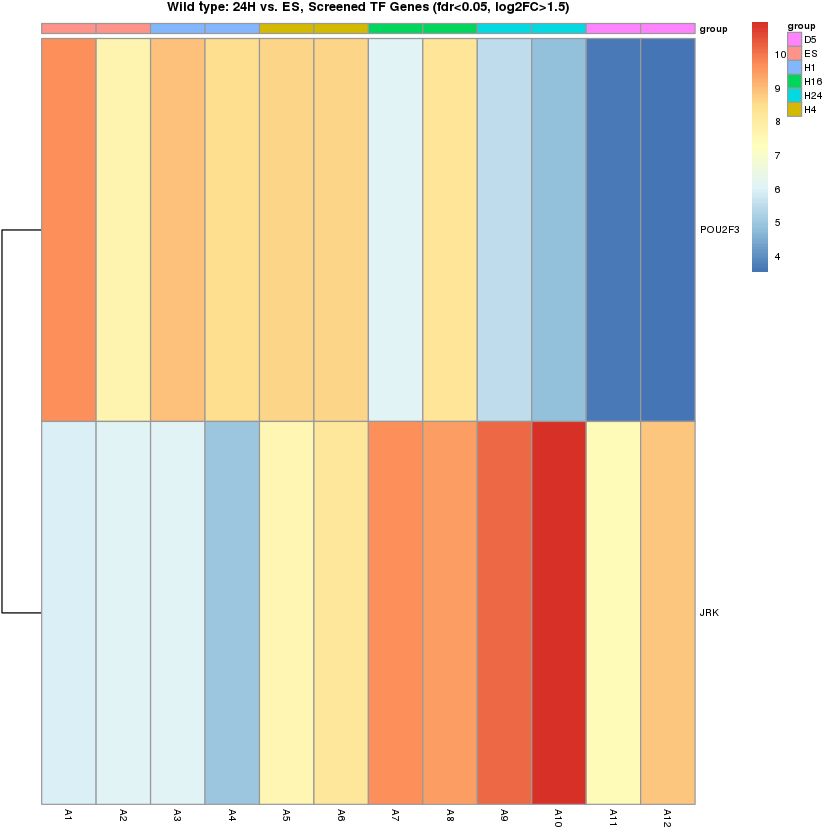

In [159]:
tf.heatmap.genes.3d <- res3d_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character
cnts3_tf[,c(2:14)] %>% filter(gene_name %in% tf.heatmap.genes.3d) %>% column_to_rownames('gene_name') %>% as.matrix %>% apply(2, sqrt) %>%
                pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, annotation = ano3, fontsize=6, treeheight_row=20,
                main = paste0('Wild type: 24H vs. ES, Screened TF Genes (fdr<',fdr,', log2FC>',FC.threshold,')'))

In [163]:
res3e_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character

[1] "PAX6"    "PAX7"    "ETV7"    "POU2F2"  "SPO11"   "SP100"   "BCL3"   
 [8] "REST"    "TRIP6"   "POU4F3"  "TRPS1"   "ANKRD7"  "POU6F2"  "AHR"    
[15] "AEBP1"   "LHX3"    "NANOG"   "RFX4"    "HAND1"   "IRX4"    "OTX1"   
[22] "IRF6"    "TCF21"   "PHF19"   "ESRRB"   "HOXB1"   "TBX22"   "TWIST1" 
[29] "NEUROG3" "GCM2"    "FOXA2"   "NKX2-2"  "SIX1"    "SOX15"   "PDLIM4" 
[36] "PPARG"   "TRIM22"  "DDB2"    "SOX3"    "SPOCD1"  "ETS1"    "EMX1"   
[43] "NKX2-8"  "DMRT1"   "TFAP2A"  "IRF4"    "HMGA1"   "POU2F3"  "SSB"    
[50] "RXRG"    "ANKRD1"  "VAX1"    "FLI1"    "EEF1A1"  "LMX1A"   "EN1"    
[57] "ELF3"    "FEV"     "HEYL"    "SFMBT1"  "NAB2"    "PTF1A"   "SOX14"  
[64] "NHLH1"   "UTF1"    "ZNF217"  "ATOH1"   "FOSL1"   "FOXE1"   "ZFP42"  
[71] "HCLS1"   "NKX2-5"  "ZFP36L1" "ZNF490"  "ZNF565"  "ESRRG"   "ZNF469" 
[78] "SPIB"

In [164]:
cnts3_tf %>% head

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000001167.14,399.06247,337.02998,316.86174,329.42452,341.7029,288.71375,326.53355,351.54329,397.59950,399.71504,469.24637,504.03772,NFYA
ENSG00000004848.8,185.23817,160.94901,148.40360,190.79170,176.9972,185.72744,159.67059,186.51325,152.79650,130.78611,115.91687,112.16417,ARX
ENSG00000005007.12,58.31572,31.63955,86.90301,48.04108,67.6031,63.37619,54.66200,52.73149,50.38451,54.76668,65.08701,57.48414,UPF1
ENSG00000005339.14,129.20934,143.06579,140.38179,131.76981,127.8313,105.62698,156.79364,133.78175,144.03398,129.96869,143.81130,161.93701,CREBBP
ENSG00000005513.10,58.31572,78.41106,82.89210,76.86572,67.6031,50.17282,56.10048,39.06037,49.28920,73.56719,48.97023,60.98927,SOX8
ENSG00000005801.18,165.79959,188.46166,212.57813,182.55609,200.3510,169.00317,188.44007,199.20787,175.25047,200.26623,185.96289,184.36985,ZNF195


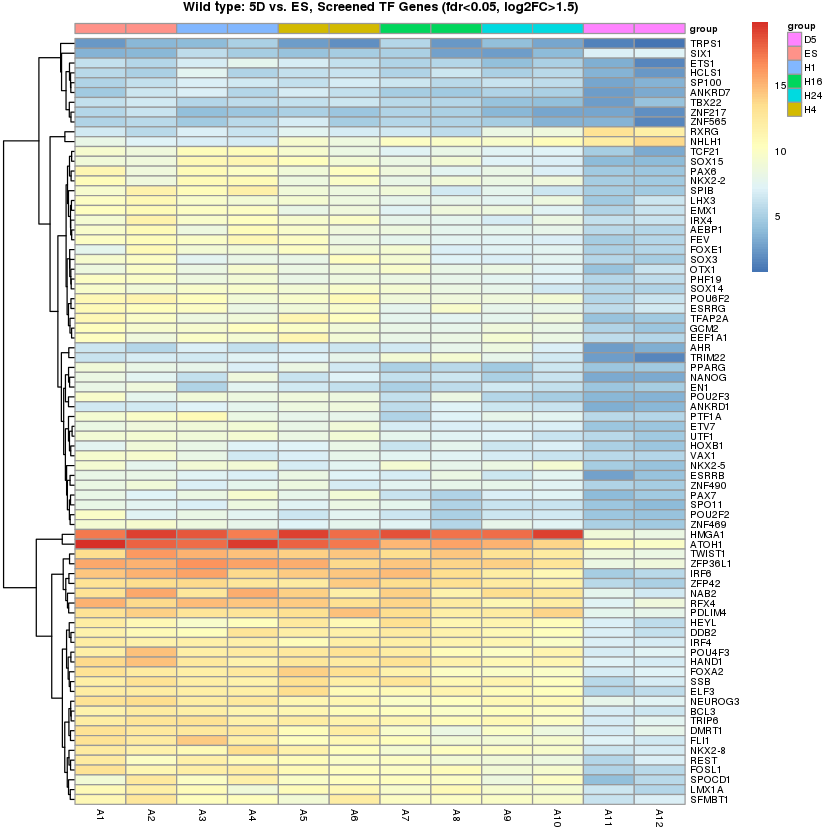

In [166]:
tf.heatmap.genes.3e <- res3e_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character
cnts3_tf[,c(2:14)] %>% filter(gene_name %in% tf.heatmap.genes.3e) %>% column_to_rownames('gene_name') %>% as.matrix %>% apply(2, sqrt) %>%
                pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, annotation = ano3, fontsize=6, treeheight_row=40,
                main = paste0('Wild type: 5D vs. ES, Screened TF Genes (fdr<',fdr,', log2FC>',FC.threshold,')'))

In [157]:
for (x in list(tf.heatmap.genes.3a, tf.heatmap.genes.3b, tf.heatmap.genes.3c, tf.heatmap.genes.3d, tf.heatmap.genes.3e)) {
    print(length(x))
}

ERROR: Error in eval(expr, envir, enclos): object 'tf.heatmap.genes.3a' not found


In [158]:
tf.heatmap.genes.3a %>% sort %>% paste(" ", collapse="") # 1H up or down regulated

ERROR: Error in eval(lhs, parent, parent): object 'tf.heatmap.genes.3a' not found


In [254]:
tf.heatmap.genes.3b %>% sort %>% paste(" ", collapse="") # 4H up or down regulated

[1] "AEBP2  ELAVL2  FOXP1  FOXP3  GFI1  IRF3  ISL2  MYBL1  PAPOLA  PHF21B  SMAD9  TBX5  TFAP2E  TLX3  XAB2  ZBTB7A  ZNF347  "

In [255]:
tf.heatmap.genes.3c %>% sort %>% paste(" ", collapse="") # 16H up or down regulated

[1] "CBX4  CRTC1  DMRT1  ELAVL2  ELF5  FEV  FOXC1  FOXL2  FOXP1  HOXA13  IRF3  ISL2  JRK  LBX1  NEUROG3  ONECUT1  PAPOLA  PEG3  SMAD9  TCF15  VSX1  XAB2  ZIM2  ZNF175  ZNF596  "

In [256]:
tf.heatmap.genes.3d %>% sort %>% paste(" ", collapse="") # 14H up or down regulated

[1] "CBX4  ELAVL2  EYA2  FOXC1  FOXP1  FOXP3  IRF3  ISL2  JRK  MYBL1  ONECUT1  PAPOLA  SAFB2  SMAD9  XAB2  ZBTB7A  ZNF175  ZNF467  "

In [258]:
tf.heatmap.genes.3e %>% sort %>% paste(" ", collapse="") # 5D up or down regulated

[1] "AEBP1  AEBP2  AIRE  ANKRD1  ATOH1  BCL3  CBX4  CDX1  DDB2  DLX4  EEF1A1  EGR4  ELAVL2  ELF3  ELF4  ELL3  EMX1  EYA2  FEV  FLI1  FOSL1  FOXA2  FOXC1  FOXL2  FOXP1  FOXP3  FOXQ1  GLI2  HMGA1  HOXB1  HOXD12  ID2  IRF3  IRF6  ISL2  JRK  JUND  KLF14  KLF8  LBX1  LHX3  LHX9  LMX1A  MIXL1  NANOG  NFE2  NHLH1  NKX2-5  NR2F6  ONECUT1  PAPOLA  PAX4  PAX5  PAX6  PCGF2  PDLIM4  PEG3  POU6F2  PRDM12  RAX  RFX4  SAFB2  SEC14L2  SMAD9  SOX21  SOX7  SOX8  SPO11  SPOCD1  SSB  TBX4  TCF15  TFCP2L1  TFEB  TP73  TRIP6  TSC22D3  TWIST2  XAB2  YBX2  ZBTB7A  ZFP36L1  ZFP42  ZIM2  ZNF175  ZNF354C  ZNF467  ZNF512  "

---

# Analyze by promoter region peaks 
(not by differential analysis on readcounts of peaks)

In [307]:
promoters <- counts(dds3, normalized=T) %>% as.data.frame %>% add_column(gene_name = mcols(dds3)$gene_name, .before = 'A1') %>% rownames_to_column('gene_id')

In [308]:
promoters %>% head

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000187634.12,SAMD11,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,0.0000,0.0000,0.00000,40.64255,58.07033,0.00000
ENSG00000188976.11,NOC2L,63.87423,0.00000,0.00000,266.4011,187.2788,0.00000,0.0000,142.2818,99.79626,71.72215,0.00000,55.84005
ENSG00000187961.14,KLHL17,63.87423,0.00000,0.00000,266.4011,187.2788,0.00000,0.0000,142.2818,99.79626,71.72215,0.00000,55.84005
ENSG00000187583.10,PLEKHN1,44.48384,114.34505,90.01161,138.2406,0.0000,92.57798,0.0000,124.1385,79.42968,98.81719,29.62772,0.00000
ENSG00000187642.9,PERM1,0.00000,44.86958,0.00000,0.0000,0.0000,0.00000,0.0000,0.0000,57.02644,0.00000,0.00000,26.91087
ENSG00000188290.10,HES4,92.38951,248.95379,98.45020,217.4409,143.2871,138.86698,194.6262,159.4702,181.26260,166.55478,113.17789,172.22957


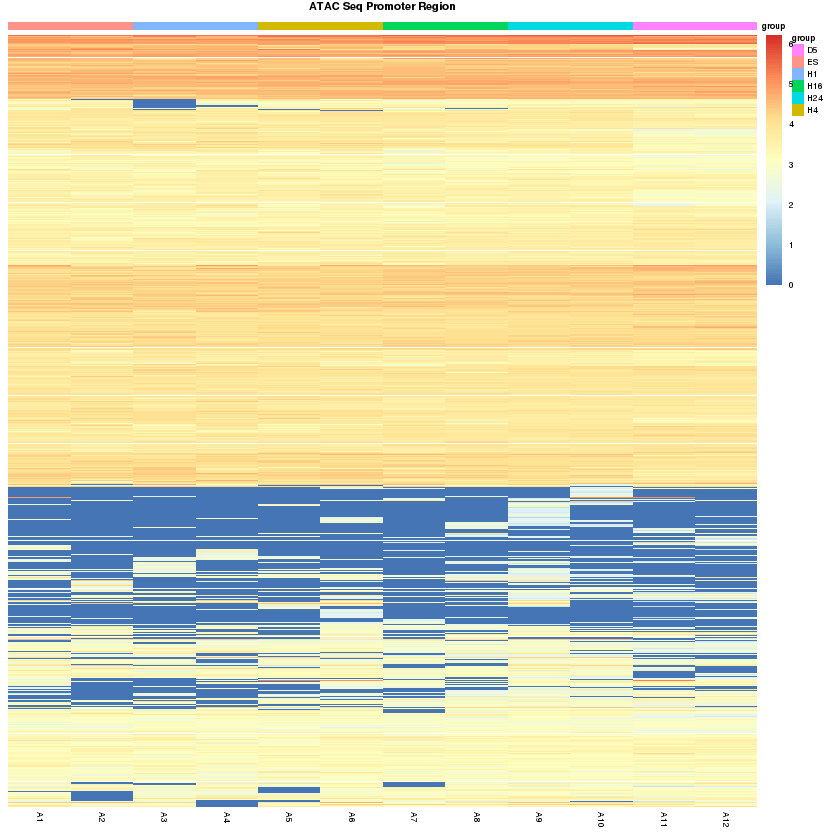

In [314]:
promoters[,c(1,3:14)] %>% column_to_rownames('gene_id') %>% as.matrix %>% apply(2, quadroot) %>%
                pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, annotation = ano3, fontsize=5, treeheight_row=0,
                main = paste0('ATAC Seq Promoter Region'))

In [315]:
# promoter region open at 1H

In [340]:
promoters %>% filter((A3 > 0 & A4 > 0) & A1 + A2 + A5 + A6 + A7 + A8 + A9 + A10 + A11 + A12 < 1)

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000204542.2,C6orf15,0,0,30.94149,109.44046,0,0,0,0,0,0,0,0
ENSG00000204540.10,PSORS1C1,0,0,30.94149,109.44046,0,0,0,0,0,0,0,0
ENSG00000179142.2,CYP11B2,0,0,29.53506,24.48010,0,0,0,0,0,0,0,0
ENSG00000134588.12,USP26,0,0,71.72800,38.88017,0,0,0,0,0,0,0,0


In [402]:
promoters %>% filter(str_detect(gene_name, 'ZBTB18'))

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000179456.10,ZBTB18,351.3083,263.4278,402.2394,276.4812,326.7952,365.9451,401.048,426.8454,464.3581,408.8163,433.1573,419.8096


In [405]:
promoter_peaks %>% filter(gene_id == 'ENSG00000179456.10')

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000179456.10,1,1,1,1,1,1,1,1,1,1,1,1


In [344]:
# promoter region open at 5D only
promoters %>% filter((A11 > 0 & A12 > 0) & A1 + A2 + A5 + A6 + A7 + A8 + A9 + A10 + A3 + A4 < 1)

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000157216.15,SSBP3,0,0,0,0,0,0,0,0,0,0,18.36919,26.910870
ENSG00000158488.16,CD1E,0,0,0,0,0,0,0,0,0,0,11.25853,18.164837
ENSG00000094963.14,FMO2,0,0,0,0,0,0,0,0,0,0,28.44261,25.565326
ENSG00000179915.23,NRXN1,0,0,0,0,0,0,0,0,0,0,27.85006,42.384620
ENSG00000168878.17,SFTPB,0,0,0,0,0,0,0,0,0,0,10.07342,12.109891
ENSG00000183054.11,RGPD6,0,0,0,0,0,0,0,0,0,0,9.48087,6.727717
ENSG00000188674.11,C2orf80,0,0,0,0,0,0,0,0,0,0,27.25750,45.748479
ENSG00000123992.19,DNPEP,0,0,0,0,0,0,0,0,0,0,27.85006,35.656902
ENSG00000171951.5,SCG2,0,0,0,0,0,0,0,0,0,0,61.03310,48.439566


##### number of peaks per gene at different time point

In [346]:
promoter_peaks <- read.delim(file = 'ATAC_Promoter_NumberofPeaks.txt', header = T, sep = '\t', stringsAsFactors = F) %>% mutate_all(~ replace(.x, is.na(.x), 0))

In [348]:
promoter_peaks %>% head

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972.5,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232.5,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000278267.1,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000243485.5,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000284332.1,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0,0,0,0,0,0,0,0


In [358]:
keep4 <- promoter_peaks %>% column_to_rownames('gene_id') %>% rowSums %>% `>`(1)

In [362]:
promoter_peaks[keep4,] %>% filter((A11 > 0 & A12 > 0) & A1 + A2 + A5 + A6 + A7 + A8 + A9 + A10 + A3 + A4 < 1)

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000157216.15,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000158488.16,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000094963.14,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000179915.23,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000168878.17,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000183054.11,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000188674.11,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000123992.19,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000171951.5,0,0,0,0,0,0,0,0,0,0,1,1


# $$X=PA$$
# $$x_{ij} = \sum\limits_{k \in TFs} b_{ik}a_{kj}$$



# Other

> **_If you can't explain it simply, you don't understand it well enough._**

## Check gene names compatibility
Check to see if the gene names in Congyi's screen data is the same as gencode annotation. Congyi's gene names are likely NCBI Refseq's names.